## Load spread sheet

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE

from source import load_avenio_files
from transform import dummy_encode_mutations, mutation_train_test_split

RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

In [2]:
# Load data from spreadsheet and SPSS files.
mutation_data_frame, phenotypes = load_avenio_files()

To make a fair comparison we should split the data in a training and validation set by randomly selecting patients. 

In [3]:
# Fraction of dataset we want to use for the validation set.
f_val = 0.3
# Split accordingly.
train_mutations, test_mutations = mutation_train_test_split(
    mutation_data_frame, test_fraction=f_val,
)

## Aggregated statistics mutation
Let us first look at the data as a whole (not just the training data), to explore the dataset.

In [4]:
# Focus only on the genes
columns_to_keep = ['Patient ID', 'Gene']
mutation_data_frame = mutation_data_frame[columns_to_keep]

        Patient ID
Gene              
ALK              1
APC              2
AR               4
BRAF             9
CCND1            1
CD274            1
CDKN2A           7
CTNNB1           3
DDR2             1
EGFR             5
ERBB2            2
ESR1             1
FBXW7            5
FGFR1            1
FGFR2            1
FLT4             1
GATA3            2
GNAS             1
IDH1             3
IDH2             1
JAK2             1
KDR              2
KEAP1            5
KIT              1
KRAS            43
MAP2K1           1
MAP2K2           1
MET              1
MTOR             3
NF2              1
NFE2L2          11
NRAS             1
PDGFRA           1
PIK3CA          13
PTCH1            2
PTEN             4
RNF43            1
SMAD4            3
SMO              2
STK11            6
TP53           120
TSC2             1
['TP53' 'KRAS' 'FGFR1' 'PTEN' 'FBXW7' 'KDR' 'MTOR' 'EGFR' 'MET' 'CDKN2A'
 'BRAF' 'APC' 'KEAP1' 'ALK' 'AR' 'ERBB2' 'NRAS' 'NFE2L2' 'TSC2' 'GNAS'
 'STK11' 'CD274' 'CT

Text(0, 0.5, '# occurences')

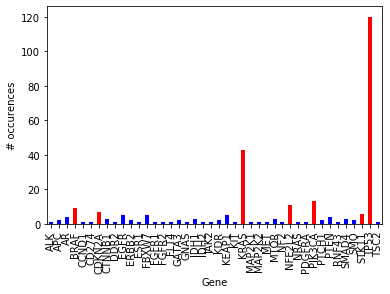

In [30]:
# Count occurences of genes, regardless of how many per patient.
gene_set = mutation_data_frame['Gene'].unique()
gene_count  = mutation_data_frame.groupby('Gene') \
    .count()

print(gene_count)

print(gene_set)
# Plot occurences of genes, and make all genes with more than 3 instances red.
gene_colour = gene_count['Patient ID'].apply(lambda x: 'red' if x > 5 else 'blue')
ax = gene_count['Patient ID'].plot(kind='bar', color=gene_colour)
ax.set_ylabel('# occurences')

Clearly, the majority of the mutations are unique, whilst the presence of TP53 is quite ubiquitous. 

How are the mutations distributed? One per patient?

(1, 11)

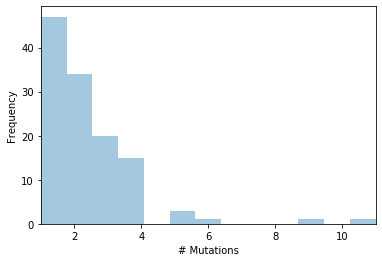

In [6]:
# How many mutations per patient?
mutation_counts = mutation_data_frame.groupby('Patient ID').count()
ax = sns.distplot(mutation_counts, kde=False)
ax.set_xlabel('# Mutations')
ax.set_ylabel('Frequency')
ax.set_xlim([1, max(mutation_counts['Gene'])])

The figure above indicates that patients usually have one or two mutations. 

It can happen that there are multiple mutations in the same gene. 
How often does this occur?

In [7]:
# How many patients have more than 1 mutation in the same gene?
# Group by (patient, gene):
num_gene_mutations = mutation_data_frame.groupby(columns_to_keep) \
    .size() \
    .to_frame('size')
# More than 1.
same_gene_mutations = num_gene_mutations[num_gene_mutations['size'] > 1]

# Fraction of total.
num_patients_multi_mutation = len(same_gene_mutations.groupby('Patient ID'))
num_patients = mutation_data_frame['Patient ID'].nunique()
f = num_patients_multi_mutation / num_patients

print('Number of patients with multiple mutations in same gene: {}/{} ({:.2f} %)'.format(
    num_patients_multi_mutation, 
    num_patients, 
    f * 100.0),
)

same_gene_mutations

Number of patients with multiple mutations in same gene: 22/122 (18.03 %)


,,size
Patient ID,Gene,
957,TP53,2
1022,TP53,2
1038,TP53,2
1057,TP53,2
1069,TP53,2
1077,TP53,3
1080,TP53,2
1090,KRAS,2
1104,KRAS,2


But how many mutations, and what mutations?

size                                         
      count  mean      std  min  25%  50%   75%  max
Gene                                                
KRAS    3.0  2.00  0.00000  2.0  2.0  2.0  2.00  2.0
STK11   1.0  2.00      NaN  2.0  2.0  2.0  2.00  2.0
TP53   20.0  2.35  0.67082  2.0  2.0  2.0  2.25  4.0

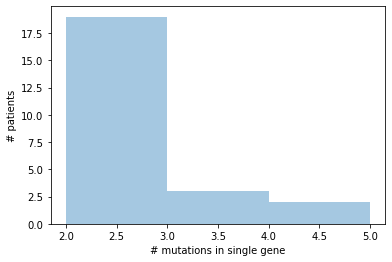

In [8]:
# Plot distribution of patients with at least two mutations.
ax = sns.distplot(
    same_gene_mutations, 
    kde=False,
    bins=[2, 3, 4, 5],
)
ax.set_xlabel('# mutations in single gene')
ax.set_ylabel('# patients')

# Multiple mutations in same gene occurs almost solely in TP53.
same_gene_mutations.groupby('Gene').describe()

## Phenotypes


/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


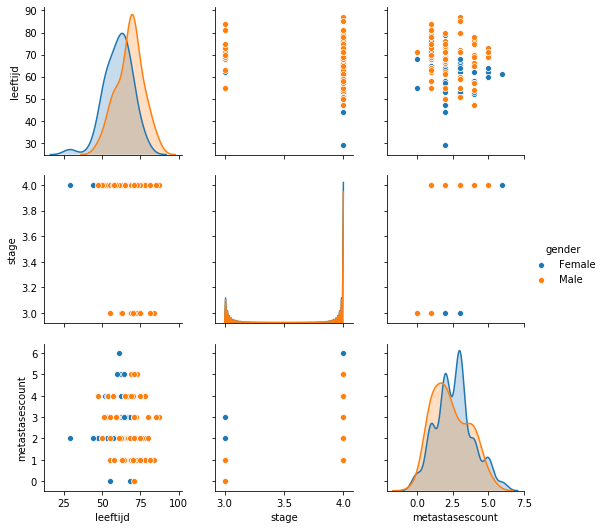

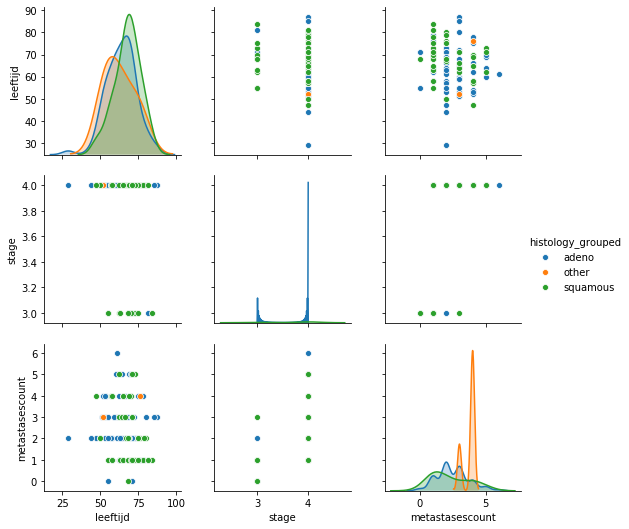

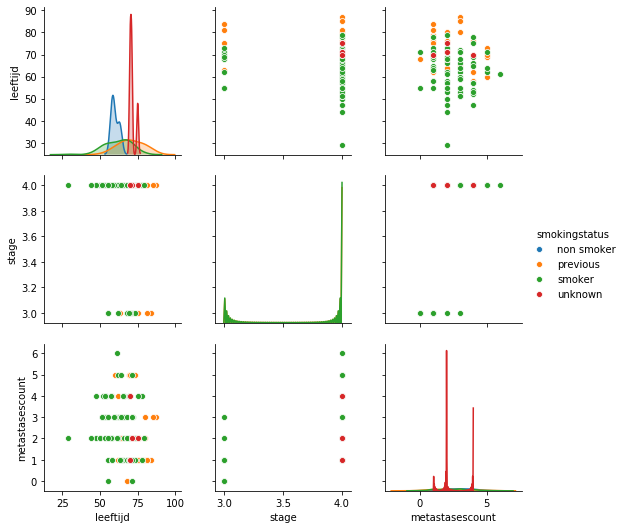

In [9]:
phenotypes.columns[:20]
features_to_investigate = ['gender', 'leeftijd', 'stage', 'smokingstatus', 'histology_grouped', 'metastasescount']
sns.pairplot(phenotypes[features_to_investigate], hue='gender')
sns.pairplot(phenotypes[features_to_investigate], hue='histology_grouped')
sns.pairplot(phenotypes[features_to_investigate], hue='smokingstatus')

## Text analysis

We can borrow some tricks that are also used in text analysis. For example, in the bag-of-words approach one collects all words (the vocabulary) and counts the occurences of each word per text document. I will do the same below: with _gene_ $\leftrightarrow$ _word_ and _text document_ $\leftrightarrow$ _patient_. That is, for each patient (row) count the number of mutations per gene (column). 

In [10]:
# Vocabulary is the entire dataset, not only training set. Otherwise we run into problems during inference.
gene_vocabulary = mutation_data_frame['Gene'].unique()

dummy_data_frame = dummy_encode_mutations(train_mutations, gene_vocabulary)

Combine with phenotype data

In [11]:
phenotypes_to_keep = ['Clinical_Response', 'response_grouped', 'leeftijd', 'progressie']
df_with_phenotype = pd.merge(
    left=dummy_data_frame,
    right=phenotypes[phenotypes_to_keep],
    left_index=True,
    right_index=True,
)

In [12]:
train_mutations['Patient ID'].unique()
# train_data_frame.set_index('Patient ID').loc[1022]

array([ 952,  965,  972,  981,  985,  986,  990,  993, 1002, 1003, 1008,
       1015, 1016, 1022, 1023, 1024, 1031, 1035, 1037, 1038, 1047, 1051,
       1054, 1063, 1066, 1069, 1070, 1075, 1077, 1081, 1083, 1086, 1096,
       1099, 1101, 1104, 1105, 1111, 1112, 1117, 1118, 1120, 1127, 1132,
       1133, 1137, 1140, 1143, 1149, 1150, 1153, 1158, 1168, 1172, 1173,
       7005, 7007, 7016, 7021, 7022, 7024, 7027, 7035, 7036, 7038, 7059,
       7071, 7073, 7075, 7090, 7093, 7098, 7103, 7110, 7117, 7120, 7123,
       7133, 7135, 7150, 7151, 7153, 7155, 7162, 7183, 7186])

In [13]:
# Validate that the code above is correct.
assert dummy_data_frame.loc[1022]['TP53'] == 2
assert dummy_data_frame.loc[1172]['TP53'] == 4
assert dummy_data_frame.loc[1172]['STK11'] == 2

## Decomposition on counts
Let us first do a decomposition using non-negative matrix factorisation (NMF):
$$X = WH$$

In [14]:
n_components = 3
nmf_decomp = NMF(n_components).fit(dummy_data_frame)
W = nmf_decomp.transform(dummy_data_frame)
H = nmf_decomp.components_

# Add jittering to help visualisation.
W_jit = W + np.random.normal(scale=0.025, size=W.shape)

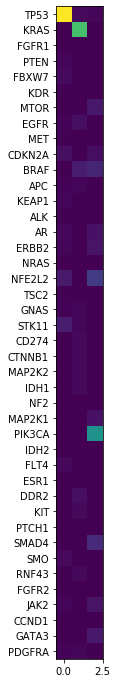

In [15]:
plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.set_yticks(range(0, H.shape[1]))
ax.set_yticklabels(dummy_data_frame.columns)
plt.imshow(H.T)

So it seems that the components are completely determined by the presence of TP53 and KRAS.

Now lets zoom in on the response:

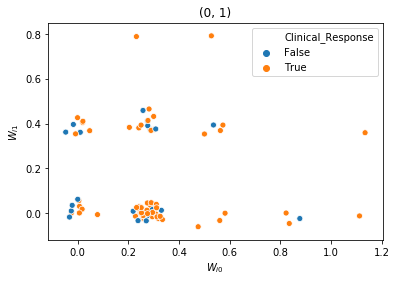

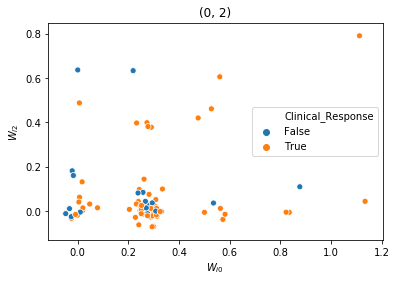

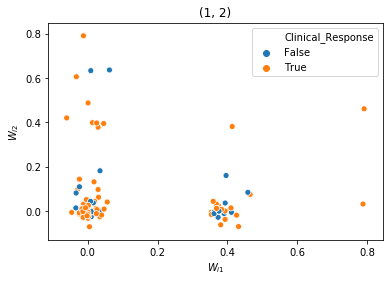

In [16]:
# Add jittering to help visualisation.
non_response = (df_with_phenotype['Clinical_Response'] == 'SD') | (df_with_phenotype['Clinical_Response'] == 'PD')
for i in range(n_components):
    for j in range(i + 1, n_components):
        plt.figure()
        plt.title('({}, {})'.format(i, j))
        plt.xlabel(r'$W_{i' + str(i) + '}$')
        plt.ylabel(r'$W_{i' + str(j) + '}$')
        sns.scatterplot(W_jit[:,i], W_jit[:,j], hue=non_response, x_jitter=True, y_jitter=True)

In turns out that patients with stable disease (SD)have no KRAS.

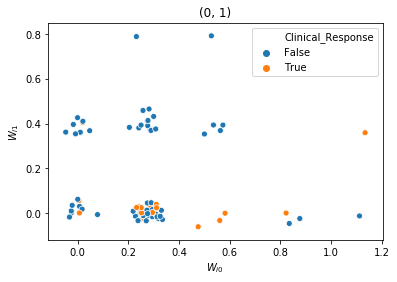

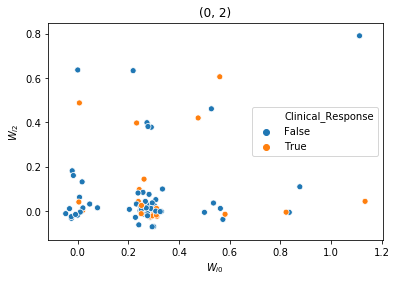

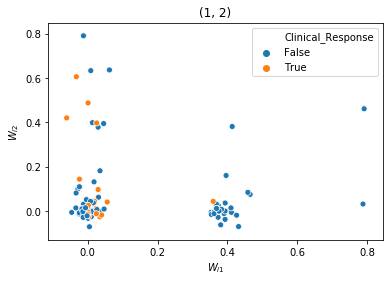

In [17]:
for i in range(n_components):
    for j in range(i + 1, n_components):
        plt.figure()
        plt.title('({}, {})'.format(i, j))
        plt.xlabel(r'$W_{i' + str(i) + '}$')
        plt.ylabel(r'$W_{i' + str(j) + '}$')
        sns.scatterplot(W_jit[:, i], W_jit[:, j], hue=df_with_phenotype['Clinical_Response'] == 'SD')

### PCA
PCA essentially gives the same results as NMF.

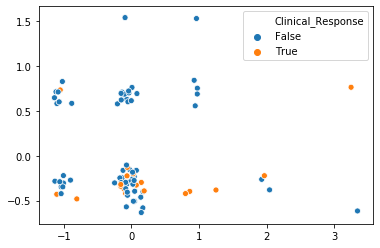

In [18]:
pca_decomp = PCA(n_components=2).fit(dummy_data_frame)
L = pca_decomp.transform(dummy_data_frame)
# Add jittering to help visualisation.
L += np.random.normal(scale=0.075, size=L.shape)
sns.scatterplot(L[:,0], L[:,1], hue=df_with_phenotype['Clinical_Response'] == 'SD')

### t-SNE

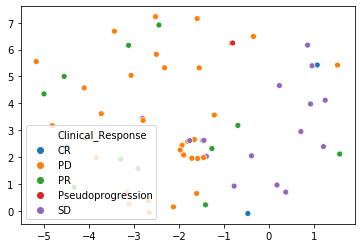

In [19]:
X_embed = TSNE(n_components=2).fit_transform(dummy_data_frame)
sns.scatterplot(X_embed[:,0], X_embed[:,1], hue=df_with_phenotype['Clinical_Response'])

## Term frequency - inverse document frequency (TF-IDF)
Since the matrix decomposition is completely dominated by TP53 and KRAS, let us use TF-IDF to help find patterns.

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
X_tfidf = TfidfTransformer().fit_transform(dummy_data_frame)

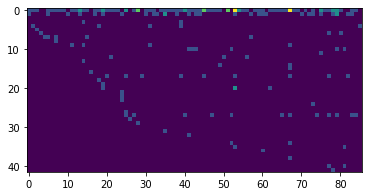

In [21]:
plt.imshow(dummy_data_frame.T)

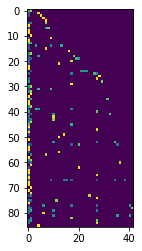

In [22]:
plt.imshow(X_tfidf.toarray())

Lets do the same NMF trick again and see if the result differ substantially.

In [23]:
n_components = 3
nmf_decomp = NMF(n_components).fit(X_tfidf)
W_tfidf = nmf_decomp.transform(X_tfidf)
H_tfidf = nmf_decomp.components_

# Add jittering to help visualisation.
W_jit2 = W_tfidf + np.random.normal(scale=0.025, size=W_tfidf.shape)

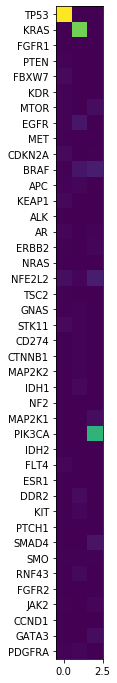

In [24]:
plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.set_yticks(range(0, H_tfidf.shape[1]))
ax.set_yticklabels(dummy_data_frame.columns)
plt.imshow(H_tfidf.T)

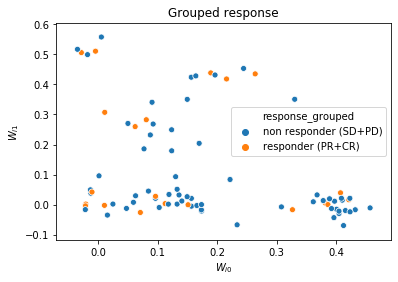

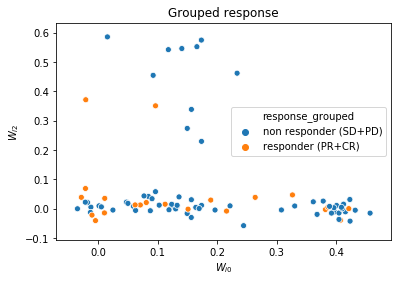

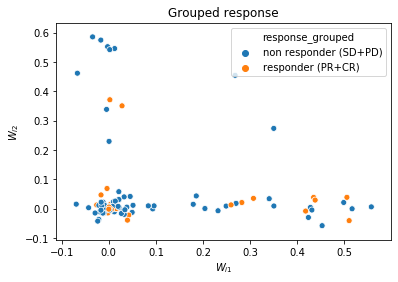

In [25]:
# Add jittering to help visualisation.
for i in range(n_components):
    for j in range(i + 1, n_components):
        plt.figure()
        plt.title('({}, {})'.format(i, j))
        plt.xlabel(r'$W_{i' + str(i) + '}$')
        plt.ylabel(r'$W_{i' + str(j) + '}$')
        plt.title('Grouped response')
        sns.scatterplot(W_jit2[:,i], W_jit2[:,j], hue=df_with_phenotype['response_grouped'], x_jitter=True, y_jitter=True)

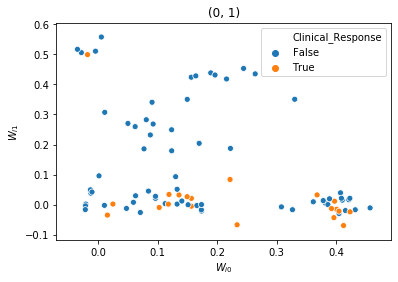

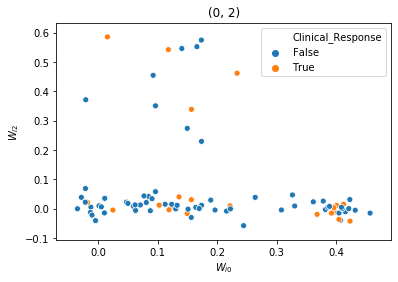

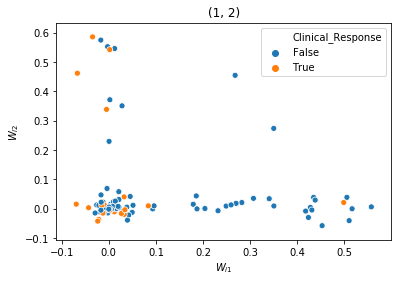

In [26]:
for i in range(n_components):
    for j in range(i + 1, n_components):
        plt.figure()
        plt.title('({}, {})'.format(i, j))
        plt.xlabel(r'$W_{i' + str(i) + '}$')
        plt.ylabel(r'$W_{i' + str(j) + '}$')
        sns.scatterplot(W_jit2[:, i], W_jit2[:, j], hue=df_with_phenotype['Clinical_Response'] == 'SD')